# Geoids Fit to North America

In geodetic applications, a *geoid* represents an equipotential surface of the Earth's gravity field that closely corresponds to global mean sea level (MSL). It acts as a reference for orthometric heights, which are used in topographic maps, engineering, and water resource studies.

Unlike global geoid models (e.g., EGM2008 or EGM96), which provide undulations relative to a geocentric ellipsoid (an ellipsoid centered at the Earth's center of mass), North American regional geoid models are computed in a reference frame aligned with the North American plate. 
The ellipsoid origin in a plate-fixed frame differs from the geocenter by roughly 2.2 meters, which, if not accounted for, would produce meter-scale offsets in ellipsoidal heights. 
Regional geoid undulation models incorporate dense regional gravity measurements, GPS-on-benchmark data, and other local observations to define the equipotential surface relative to that plate-fixed ellipsoid. 
Subsequent refinements, such as new airborne/terrestrial gravity surveys (e.g., GRAV-D), updated geoid–quasigeoid separation methods, and improved interpolation—introduce further decimeter-level or smaller adjustments to the geoid undulation field.

It’s important to note that the geoid is *not* itself a vertical datum, though it underpins vertical datums: a vertical datum uses a geoid model but adds conventions, benchmarks, and adjustment networks to maintain a consistent height system over time and space.

---

## NOAA's Geoid Models

NOAA’s National Geodetic Survey (NGS) develops and maintains a series of regional geoid models for the U.S. and its territories. These include:

* [GEOID03](https://geodesy.noaa.gov/GEOID/GEOID03/)
* [GEOID09](https://geodesy.noaa.gov/GEOID/GEOID09/)
* [GEOID12B](https://geodesy.noaa.gov/GEOID/GEOID12B/)
* [GEOID18](https://geodesy.noaa.gov/GEOID/GEOID18/)

Each new model integrates improved data and techniques:

* **GEOID03** was the first full release using hybrid modeling with GPS-on-benchmark (GPSBM) constraints.
* **GEOID09** added more [GPSBM control](https://www.ngs.noaa.gov/GEOID/GPSonBM09BETA/) and updated gravimetric models.
* **GEOID12B** introduced [further refinement](https://geodesy.noaa.gov/GEOID/GEOID12B/GPSonBM12B.shtml), particularly for areas impacted by subsidence and uplift.
* **GEOID18** is the most recent geoid (not for long!) and is used for the [2022 update to the National Spatial Reference System](https://geodesy.noaa.gov/datums/newdatums/index.shtml), includes dramatically better gravity data (from GRAV-D airborne surveys), new GPSBM data, and enhanced interpolation methods. See the [technical details](https://geodesy.noaa.gov/GEOID/GEOID18/geoid18_tech_details.shtml) for more information.

Originally, these models were distributed as ASCII raster grids that provided geoid undulation (height above the reference ellipsoid) values. 
While these ASCII files are still available (e.g. https://geodesy.noaa.gov/PC_PROD/GEOID03/) the data is now also hosted as Cloud-Optimized GeoTIFFs (COGs) on cdn.proj.org. 
This modern format is much more efficient and accessible for direct use in geospatial software and cloud-based workflows, as it allows for streaming only the required portions of the data. 
In this notebook, we will read these COG files directly into `xarray.DataArray` objects to visualize and compare them.

```{note}
The numbers in the geoid model names indicate the release year. 
For example, GEOID09 was released in 2009, GEOID18 in 2018, etc. Suffix letters (like "A" or "B") denote major revisions or corrections within that release cycle.
```

In [3]:
import rioxarray
import matplotlib.pyplot as plt

def load_geoid_cog(url):
    """
    Open a cloud-optimized GeoTIFF geoid model directly from a URL
    and return it as an xarray.DataArray.
    """
    xda = rioxarray.open_rasterio(url, chunks='auto')
    return xda.squeeze('band', drop=True)

# URLs for the COG-formatted geoid models
urls_cog = {
    "GEOID03": 'https://cdn.proj.org/us_noaa_geoid03_conus.tif',
    "GEOID09": 'https://cdn.proj.org/us_noaa_geoid09_conus.tif',
    "GEOID12B": 'https://cdn.proj.org/us_noaa_g2012bu0.tif',
    "GEOID18": 'https://cdn.proj.org/us_noaa_g2018u0.tif'
}

# Load each geoid model into a dictionary
geoids_cog = {}
for name, url in urls_cog.items():
    print(f"Loading {name} from: {url}")
    geoids_cog[name] = load_geoid_cog(url)
    print(f"Loaded {name}. Data structure:")
    print(geoids_cog[name])
    print("-" * 60)

Loading GEOID03 from: https://cdn.proj.org/us_noaa_geoid03_conus.tif
Loaded GEOID03. Data structure:
<xarray.DataArray (y: 2041, x: 4201)> Size: 34MB
dask.array<getitem, shape=(2041, 4201), dtype=float32, chunksize=(2041, 4201), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 34kB 230.0 230.0 230.0 230.1 ... 300.0 300.0 300.0
  * y            (y) float64 16kB 58.0 57.98 57.97 57.95 ... 24.03 24.02 24.0
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  NAD83 (EPSG:4269) to NAVD88 height (EPSG:5703)...
    TIFFTAG_DATETIME:          2019:12:27 00:00:00
    TIFFTAG_COPYRIGHT:         Derived from work by NOAA. Public Domain
    area_of_use:               USA - Conterminous
    target_crs_epsg_code:      5703
    TYPE:                      VERTICAL_OFFSET_GEOGRAPHIC_TO_VERTICAL
    AREA_OR_POINT:             Point
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 geoid_undulation
    units:          

In [ ]:
geoids_shifted = {}
print("Adjusting longitude from [0, 360] to [-180, 180]...")
for name, data in geoids_cog.items():
    lon_coord_name = data.rio.x_dim
    new_lons = (data[lon_coord_name].values + 180) % 360 - 180
    adjusted_data = data.assign_coords({lon_coord_name: new_lons}).sortby(lon_coord_name)
    geoids_shifted[name] = adjusted_data

Adjusting longitude from [0, 360] to [-180, 180]...


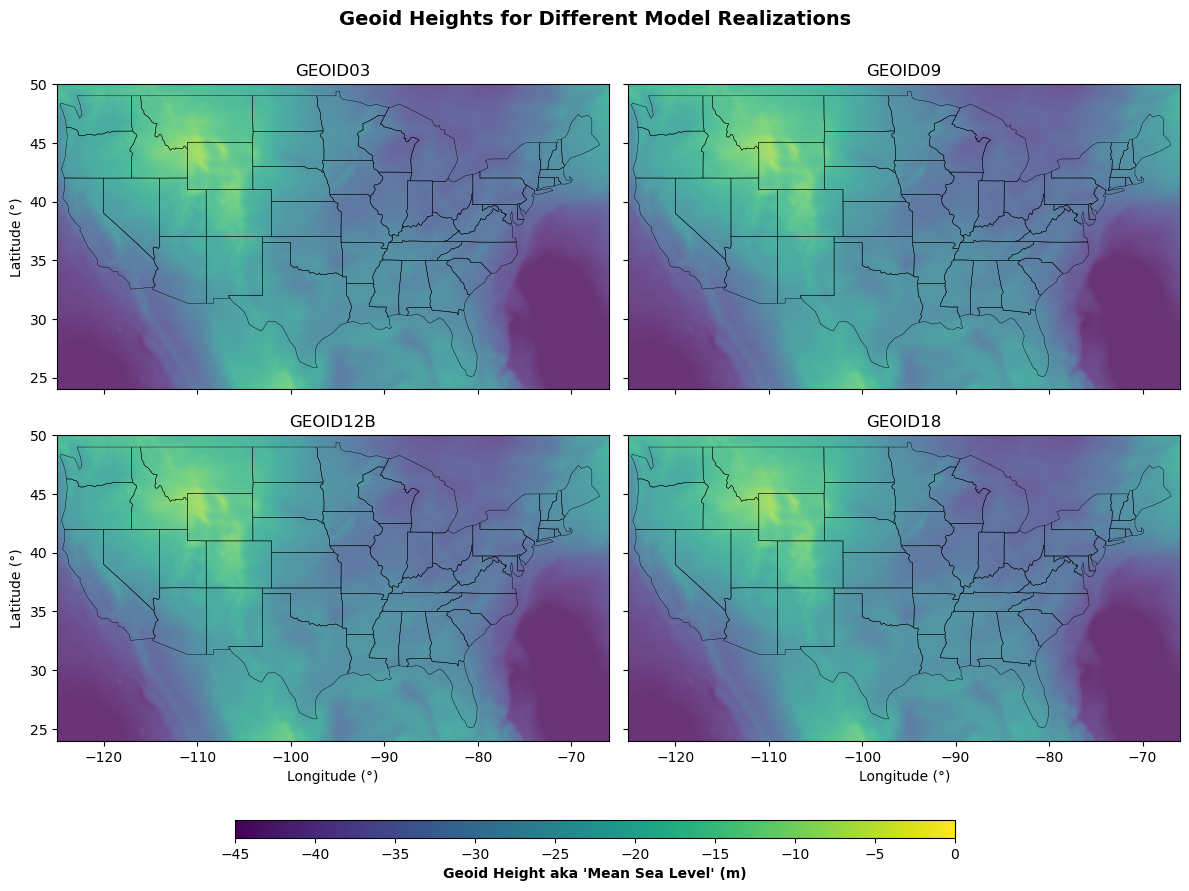

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Load Contiguous US states polygons for plotting
states = gpd.read_file(
    "https://raw.githubusercontent.com/ResidentMario/geoplot-data/master/contiguous-usa.geojson"
)

fig, axs = plt.subplots(2, 2, figsize=(12, 9), sharex=True, sharey=True)
norm = TwoSlopeNorm(vmin=-45, vcenter=-22.5, vmax=0)
cmap = 'viridis'
titles = ['GEOID03', 'GEOID09', 'GEOID12B', 'GEOID18']
data_list = [geoids_shifted[t] for t in titles]
xmin, xmax, ymin, ymax = -125, -66, 24, 50

for idx, (ax, data, title) in enumerate(zip(axs.flat, data_list, titles)):
    data.plot.imshow(ax=ax, norm=norm, cmap=cmap, alpha=0.8, add_colorbar=False)
    states.to_crs(data.rio.crs).boundary.plot(ax=ax, edgecolor='black', alpha=1, linewidth=0.3)
    ax.set(xlabel='', ylabel='', title=title,
           xlim=(xmin, xmax), ylim=(ymin, ymax))
    if idx // 2 == 1:  # Last row
        ax.set_xlabel('Longitude (°)')
    if idx % 2 == 0:  # First column
        ax.set_ylabel('Latitude (°)')

fig.suptitle("Geoid Heights for Different Model Realizations", fontsize=14, fontweight='bold', y=.93)
fig.tight_layout(rect=[0, 0.05, 1, 0.95])

cbar_ax = fig.add_axes([0.2, 0.01, 0.6, 0.02])
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax,
    orientation='horizontal'
)
cbar.set_label("Geoid Height aka 'Mean Sea Level' (m)", fontweight='bold')
plt.show()

## Geoid Heights from Four Model Realizations

When visualized directly, the geoid models appear nearly identical to the eye, especially when plotted with a colorbar spanning the full range of mean sea level (-45 to 0 meters across the U.S.). 
This masks subtle differences between the models that may be critical in applications requiring centimeter-level accuracy.

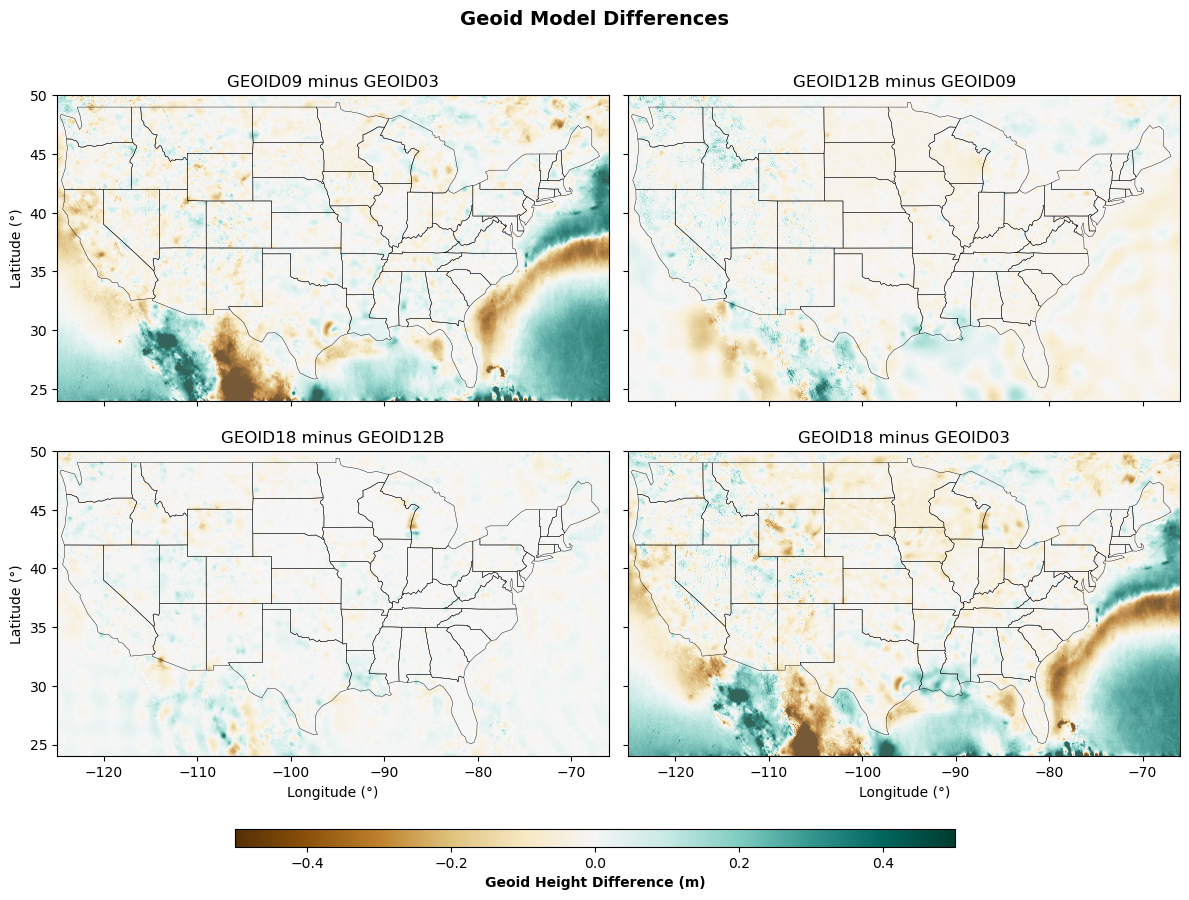

In [16]:
# Align all geoids to the GEOID18 grid for accurate pixel-to-pixel math
geoids_aligned = {}
template_grid = geoids_shifted['GEOID18']

for name, g_da in geoids_shifted.items():
    if name != 'GEOID18':
        geoids_aligned[name] = g_da.rio.reproject_match(template_grid)
    else:
        geoids_aligned[name] = g_da 

diff_pairs = [
    ("GEOID09 minus GEOID03", geoids_aligned["GEOID09"] - geoids_aligned["GEOID03"]),
    ("GEOID12B minus GEOID09", geoids_aligned["GEOID12B"] - geoids_aligned["GEOID09"]),
    ("GEOID18 minus GEOID12B", geoids_aligned["GEOID18"] - geoids_aligned["GEOID12B"]),
    ("GEOID18 minus GEOID03", geoids_aligned["GEOID18"] - geoids_aligned["GEOID03"])
]

fig, axs = plt.subplots(2, 2, figsize=(12, 9), sharex=True, sharey=True)
norm_diff = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
cmap_diff = 'BrBG'
titles_diff = [label for label, _ in diff_pairs]
data_list_diff = [diff for _, diff in diff_pairs]

for idx, (ax, data, title) in enumerate(zip(axs.flat, data_list_diff, titles_diff)):
    data.plot.imshow(ax=ax, norm=norm_diff, cmap=cmap_diff, alpha=0.8, add_colorbar=False)
    states.to_crs(data.rio.crs).boundary.plot(ax=ax, edgecolor='black', alpha=1, linewidth=0.3)
    ax.set(xlabel='', ylabel='', title=title,
        xlim=(xmin, xmax), ylim=(ymin, ymax))
    if idx // 2 == 1:
        ax.set_xlabel('Longitude (°)')
    if idx % 2 == 0:
        ax.set_ylabel('Latitude (°)')

fig.suptitle("Geoid Model Differences", fontsize=14, fontweight='bold',  y=.93)
fig.tight_layout(rect=[0, 0.03, 1, 0.94])

cbar_ax_diff = fig.add_axes([0.2, 0, 0.6, 0.02])
cbar_diff = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm_diff, cmap=cmap_diff),
    cax=cbar_ax_diff,
    orientation='horizontal'
)
cbar_diff.set_label("Geoid Height Difference (m)", fontweight='bold')
plt.show()


## Differences Between Geoid Models

The difference plots reveal key insights:

* The **GEOID09 - GEOID03** and **GEOID18 - GEOID03** comparisons show changes of **up to ±0.5 meters**, indicating substantial regional updates.
* In contrast, **GEOID12B - GEOID09** and **GEOID18 - GEOID12B** show much smoother and smaller transitions, suggesting evolutionary refinements.

The biggest changes appear:

* Along the **Pacific coast**, particularly the plate boundary zones in California and the Pacific Northwest. These areas are very tectonically active, and GPSBM data or updated gravity data contributed to significant geoid corrections.
* Across **northern Mexico**, including Sonora and Chihuahua. Sparse previous coverage combined with new data largely drove greater corrections here.
* Offshore and near the **continental margins**, where gravity modeling is often more uncertain.
* A notable **curving anomaly** from Florida up the East Coast and then out into the Atlantic suggests a gravity signal possibly linked to ancient tectonic structures or variations in the continental shelf.
* In **southern Ontario and Quebec**, glacial isostatic adjustment and post-glacial rebound influence the shape of the geoid.

These patterns highlight how new data acquisition, seismic activity, and better modeling of geophysical processes contribute to iterative geoid improvement.

---

## Why Do These Differences Matter?

Even though a **0.5 meter** change might seem small, in geodesy and Earth science, these discrepancies can be critical:

* **Flood risk mapping**: FEMA and other agencies require accurate elevations to model inundation zones. A decimeter error could misclassify properties, and thus flood insurance (which is not cheap).
* **Volcanology and deformation monitoring**: Height changes on the order of centimeters are relevant when tracking inflation or deflation of magma chambers. Remember Mt. St. Helens in 1980? And the fact that volcanic eruptions can cost airlines millions of dollars per day due to flight disruptions
* **Air and sea navigation**: Aviation safety and hydrographic charting rely on consistent vertical datums.

Inaccuracies in the geoid can cascade into large errors in derived products. This is why NOAA’s ongoing refinement of the geoid is foundational for geospatial science and infrastructure across North America.

---

```{note}
As of 2025-06-20, the NGS released the beta product versions of the 2022 National Spatial Reference System (NSRS) geoids.
This includes the North American-Pacific Geopotential Datum of 2022 which is a geoid model, and the reference ellipsoid NATRF2022 for North America.
https://beta.ngs.noaa.gov/
```